# CSCA 5622 Supervised Learning Final Project
Github public link: https://github.com/BasilPanda/CSCA-5622-FINAL

## Project Summary
### Objective
The supervised learning problem I decided to take on is a match predictor for League of Legends Esports teams. I want to be able to better predict the winning team based on past results but also to learn what key factors are the most influential in winning the match. I plan on using a Decision Tree Classifier to determine what the most influential features are. The features range from kills, deaths, assists, and towers and objectives taken.

### The Data
The data is publicly available from https://oracleselixir.com/tools/downloads which hosts all match results since 2011.

APA Citation: Oracle's Elixir. (n.d.). Downloads: Oracle's Elixir tools. Oracle's Elixir. https://oracleselixir.com/tools/downloads

## Imports

In [396]:
# Required imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier

def print_df(df):
    """
    Helper to print info and describe of the df
    """
    print(df.info())
    print(df.describe())

def get_and_clean_df(filepath):
    """
    Helper to get dataset and clean dataframes
    """
    df = pd.read_csv(filepath)
    # We need to clean the NaN/NULL fields out for ease.
    df_no_nulls = df.dropna(axis=1, how="any")
    # The dataset has partially duped rows which number close to 20,000. Remove
    # them to not pollute our data set further.
    df_no_partials = df_no_nulls[df_no_nulls["datacompleteness"] == "complete"]
    # The dataset already sums up all player values to a team.
    # We don't really care about per player stats here to predict which team
    # will win.
    df_teams_only = df_no_partials[df_no_partials["position"] == "team"]
    # We're also going to drop columns that aren't really necessary in
    # contributing to winning a match
    df_dropped = df_teams_only.drop(labels=["gameid", "datacompleteness", "year", "playoffs", "date", "game", "participantid", "position", "side", "teamname"], axis=1)
    # There's team names that are unknown, we need to remove them too otherwise
    # we'll seriously pollute our dataset
    df_dropped = df_dropped[df_dropped["teamname"] != "unknown team"]
    # We're going to only focus on the major 4 regions and international
    # tournaments for simplicity.
    # LCK = Korea
    # LPL = China
    # LEC = Europe
    # LCS = America
    # WLDs = Worlds
    # MSI = Mid Season Invitational
    df_cleaned = df_dropped[df_dropped["league"].isin(["LCK", "LEC", "LCS", "LPL", "WLDs"])]
    df_cleaned = df_cleaned.drop(labels=["league"])
    return df_cleaned


In [389]:
# Grabbing our data, for speed we've already downloaded the required data in our local repository.
df_orig = pd.read_csv("data/2024_esports_data.csv")

C:\Users\eeng2\AppData\Local\Temp\ipykernel_61608\109435543.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv("data/2024_esports_data.csv")


In [349]:
# Check the head of the data
df_orig.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,2024-01-01 05:13:15,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data
The data contains every match every played in every single Esports league in the world. The data size and descriptions can be seen below in `df.describe()`.

The key features we're focusing on are the following:
- gamelength
- result (binary win)
- kills
- deaths
- assists
- teamkills
- teamdeaths
- team kpm
- ckpm
- damagetochampions
- dpm
- damagetakenperminute
- wardsplaced
- wpm
- wardskilled
- wcpm
- controlwardsbought
- visionscore
- vspm
- totalgold
- earnedgold
- earned gpm
- goldspent
- monsterkills

In [350]:
# Let's see what datatypes we have and how many columns
print_df(df_orig)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117648 entries, 0 to 117647
Columns: 161 entries, gameid to opp_deathsat25
dtypes: float64(118), int64(20), object(23)
memory usage: 144.5+ MB
None
            year   playoffs       game      patch  participantid  gamelength  \
count 117,648.00 117,648.00 117,648.00 117,504.00     117,648.00  117,648.00   
mean    2,024.04       0.22       1.68      14.09          29.58    1,898.14   
std         0.19       0.41       0.94       0.07          57.65      337.77   
min     2,023.00       0.00       1.00      13.24           1.00      522.00   
25%     2,024.00       0.00       1.00      14.04           3.75    1,661.75   
50%     2,024.00       0.00       1.00      14.10           6.50    1,859.00   
75%     2,024.00       0.00       2.00      14.14           9.25    2,099.00   
max     2,025.00       1.00       5.00      14.23         200.00    3,482.00   

          result      kills     deaths    assists  ...  opp_csat25  \
count 117,6

## Data Cleaning

In [351]:
# Wow, 108 columns. We need to clean the NaN/NULL fields out for ease. We're
# going to remove any column that has NULL values for simplicity since there's
# simply too many columns
df_no_nulls = df_orig.dropna(axis=1, how="any")
print_df(df_no_nulls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117648 entries, 0 to 117647
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameid                117648 non-null  object 
 1   datacompleteness      117648 non-null  object 
 2   league                117648 non-null  object 
 3   year                  117648 non-null  int64  
 4   playoffs              117648 non-null  int64  
 5   date                  117648 non-null  object 
 6   game                  117648 non-null  int64  
 7   participantid         117648 non-null  int64  
 8   side                  117648 non-null  object 
 9   position              117648 non-null  object 
 10  teamname              117648 non-null  object 
 11  gamelength            117648 non-null  int64  
 12  result                117648 non-null  int64  
 13  kills                 117648 non-null  int64  
 14  deaths                117648 non-null  int64  
 15  

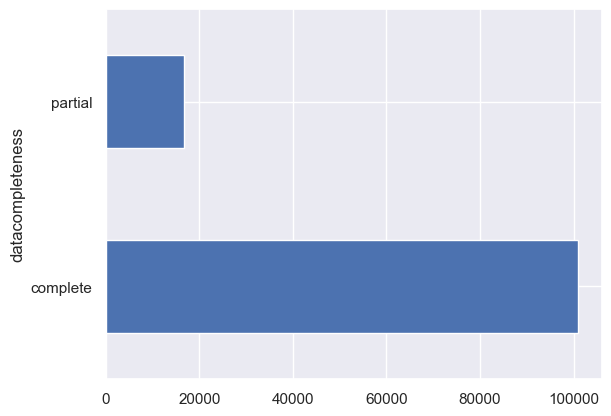

In [352]:
# 138 columns down to 28, nice.
# The dataset has partially duped rows which number close to 20,000. Remove them
# to not pollute our data set further.
df_no_nulls["datacompleteness"].value_counts().plot(kind="barh")
df_no_partials = df_no_nulls[df_no_nulls["datacompleteness"] == "complete"]

In [353]:
# The dataset already sums up all player values to a team.
# We don't really care about per player stats here to predict which team will
# win.
df_teams_only = df_no_partials[df_no_partials["position"] == "team"]

In [354]:
# We're also going to drop columns that aren't really necessary in contributing
# to winning a match
df = df_teams_only.drop(labels=["gameid", "datacompleteness", "year", "playoffs", "date", "game", "participantid", "position"], axis=1)

In [355]:
# There's team names that are unknown, we need to remove them too otherwise
# we'll seriously pollute our dataset
df = df[df["teamname"] != "unknown team"]

In [356]:
# We're going to only focus on the major 4 regions and international
# tournaments for simplicity.
# LCK = Korea
# LPL = China
# LEC = Europe
# LCS = America
# WLDs = Worlds
# MSI = Mid Season Invitational
df = df[df["league"].isin(["LCK", "LEC", "LCS", "LPL", "WLDs"])]

In [357]:
# Let's see what datatypes we have and how many columns we have now
print_df(df)

<class 'pandas.core.frame.DataFrame'>
Index: 2174 entries, 754 to 114971
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   league                2174 non-null   object 
 1   side                  2174 non-null   object 
 2   teamname              2174 non-null   object 
 3   gamelength            2174 non-null   int64  
 4   result                2174 non-null   int64  
 5   kills                 2174 non-null   int64  
 6   deaths                2174 non-null   int64  
 7   assists               2174 non-null   int64  
 8   teamkills             2174 non-null   int64  
 9   teamdeaths            2174 non-null   int64  
 10  team kpm              2174 non-null   float64
 11  ckpm                  2174 non-null   float64
 12  damagetochampions     2174 non-null   int64  
 13  dpm                   2174 non-null   float64
 14  damagetakenperminute  2174 non-null   float64
 15  wardsplaced           

In [358]:
# Perfect, we have 27 columns/ key features that all contribute to winning a
# match
print(df.columns)

Index(['league', 'side', 'teamname', 'gamelength', 'result', 'kills', 'deaths',
       'assists', 'teamkills', 'teamdeaths', 'team kpm', 'ckpm',
       'damagetochampions', 'dpm', 'damagetakenperminute', 'wardsplaced',
       'wpm', 'wardskilled', 'wcpm', 'controlwardsbought', 'visionscore',
       'vspm', 'totalgold', 'earnedgold', 'earned gpm', 'goldspent',
       'monsterkills'],
      dtype='object')


In [359]:
# Let's see the head of our data now.
print(df.head())

    league  side      teamname  gamelength  result  kills  deaths  assists  \
754    LEC  Blue      Team BDS        1749       0     10      14       11   
755    LEC   Red    G2 Esports        1749       1     14      10       26   
766    LEC  Blue         Rogue        2080       0      4      16       13   
767    LEC   Red     SK Gaming        2080       1     16       4       43   
778    LEC  Blue  Karmine Corp        2370       0      9      20       16   

     teamkills  teamdeaths  ...  wardskilled  wcpm  controlwardsbought  \
754         10          14  ...           54  1.85                  31   
755         14          10  ...           48  1.65                  32   
766          4          16  ...           56  1.62                  18   
767         16           4  ...           73  2.11                  53   
778          9          20  ...           58  1.47                  40   

     visionscore  vspm  totalgold  earnedgold  earned gpm  goldspent  \
754          2

## Data Visualizations
Now that our data is clean, we can visualize it now.

### Side Win Rate (Blue or Red)
Notoriously, blue side is known to win more professionally due to pick orders abusing meta picks

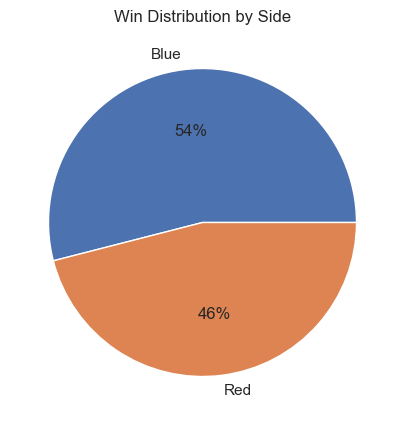

In [360]:
df_winning = df[df["result"] == 1]
counts = df_winning['side'].value_counts()
plt.figure(figsize=(5,5))
plt.title('Win Distribution by Side')
plt.pie(counts, labels=counts.index, autopct='%1.0f%%')
plt.show()

### Highest Gold
Total gold earned for the team is usually a strong influencer for the outcome of the match. Players can use the gold to buy items to become stronger than their opponents.

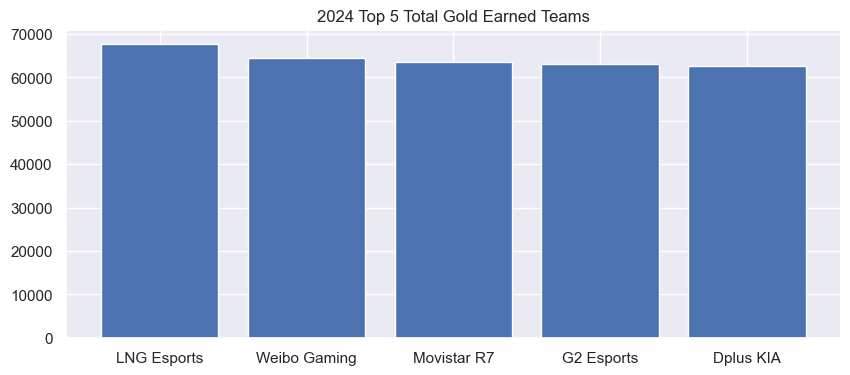

In [361]:
average_gold = df.groupby("teamname")["totalgold"].mean()
top_5_gold = average_gold.sort_values(ascending=0)[:5]
plt.figure(figsize=(10,4))
plt.title('2024 Top 5 Total Gold Earned Teams')
plt.bar(x=top_5_gold.index, height=top_5_gold)
plt.show()

## Exploratory Data Analysis

### Most Winning-est Teams
We know the top 5 gold earning teams, does this correlate to top 5 win rates?

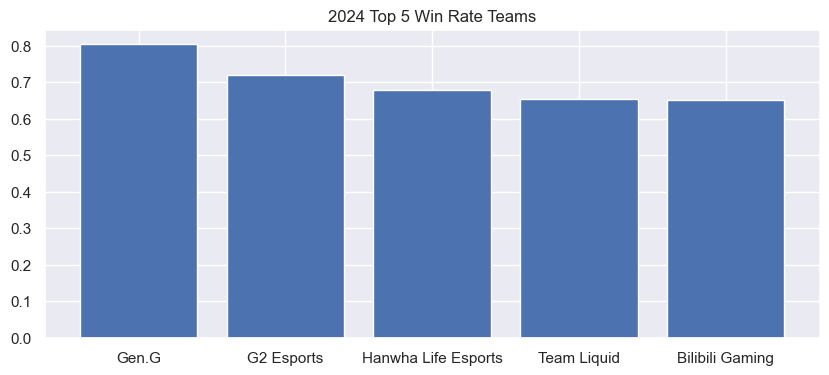

In [362]:
# Get the wins and lost games per team.
df_winning = df[df["result"] == 1]
df_losing = df[df["result"] == 0]
winning_counts = df_winning['teamname'].value_counts()
losing_counts = df_losing['teamname'].value_counts()

# Get the win rates for each team
team_win_rates = {}
for team in winning_counts.index:
    total_games = winning_counts.get(team, 0) + losing_counts.get(team, 0)
    team_win_rates[team] = winning_counts.get(team, 0) / (winning_counts.get(team, 0) + losing_counts.get(team, 0))

team_win_rates = pd.Series(team_win_rates)
top_5 = team_win_rates.sort_values(ascending=0)[:5]
plt.figure(figsize=(10,4))
plt.title('2024 Top 5 Win Rate Teams')
plt.bar(x=top_5.index, height=top_5)
plt.show()

### Bottom 5 Win Rates
For fun, I wanted to see what the bottom 5 teams were.

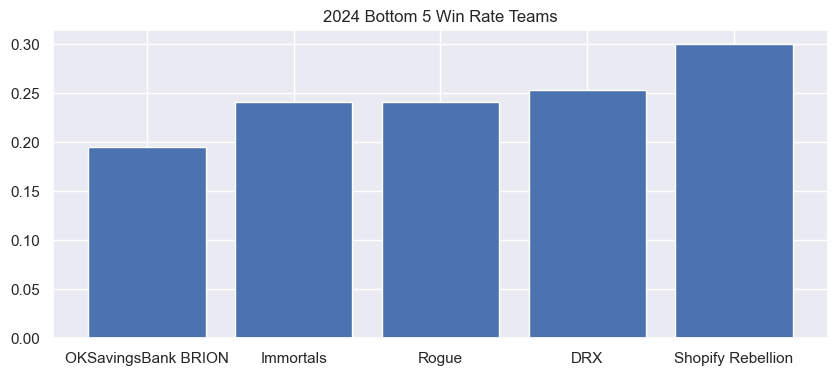

In [363]:
bot_5 = team_win_rates.sort_values(ascending=1)[:5]
plt.figure(figsize=(10,4))
plt.title('2024 Bottom 5 Win Rate Teams')
plt.bar(x=bot_5.index, height=bot_5)
plt.show()

### Who won worlds though?
Worlds is the grandest international tournament for League of Legends similar to the FIFA World Cup for soccer

In [364]:
# Grabbing the last game winner for Worlds
df_worlds = df_teams_only[df_teams_only["league"] == "WLDs"]
df_worlds.iloc[-1]

gameid                      LOLTMNT05_90307
datacompleteness                   complete
league                                 WLDs
year                                   2024
playoffs                                  0
date                    2024-11-02 17:53:48
game                                      5
participantid                           200
side                                    Red
position                               team
teamname                                 T1
gamelength                             1933
result                                    1
kills                                    12
deaths                                    6
assists                                  24
teamkills                                12
teamdeaths                                6
team kpm                               0.37
ckpm                                   0.56
damagetochampions                     54493
dpm                                1,691.45
damagetakenperminute            

### The Team That Won 2024 Worlds 
<img src="src/T1_logo.svg.png" alt="Drawing" style="width: 128px;"/>
T1 from LCK (Korea) ended up winning Worlds in 2024 but they weren't even in the top 5 win rate or top 5 total gold earned teams for the year. This is more of a fun fact because they weren't the winning-est team either.

### Data Correlation
Okay, so the assumptions I made about win rate and total gold earned clearly don't mean the most in determining a victory. 
I wanted to convert the remaining categorical data types `league`, `side`, and `teamname` to an integer as I thought maybe they influenced victory.
Let's see what the correlation matrix says then.

In [365]:
# Category features we need to convert to integers
cat_features = ["league", "side", "teamname"]
df_converted = df
for feature in cat_features:
    # Using LabelEncoder for ease
    label_enc = preprocessing.LabelEncoder()
    label_enc.fit(df[feature].unique())
    df_converted[feature] = label_enc.transform(df[feature])
    print(f"Categorical values: {df[feature]}")
    print(f"Integer values: {df_converted[feature]}")

Categorical values: 754       2
755       2
766       2
767       2
778       2
         ..
114947    3
114958    3
114959    3
114970    3
114971    3
Name: league, Length: 2174, dtype: int64
Integer values: 754       2
755       2
766       2
767       2
778       2
         ..
114947    3
114958    3
114959    3
114970    3
114971    3
Name: league, Length: 2174, dtype: int64
Categorical values: 754       0
755       1
766       0
767       1
778       0
         ..
114947    1
114958    0
114959    1
114970    0
114971    1
Name: side, Length: 2174, dtype: int64
Integer values: 754       0
755       1
766       0
767       1
778       0
         ..
114947    1
114958    0
114959    1
114970    0
114971    1
Name: side, Length: 2174, dtype: int64
Categorical values: 754       31
755       11
766       26
767       27
778       18
          ..
114947    29
114958    29
114959     2
114970     2
114971    29
Name: teamname, Length: 2174, dtype: int64
Integer values: 754       31
755  

<Axes: >

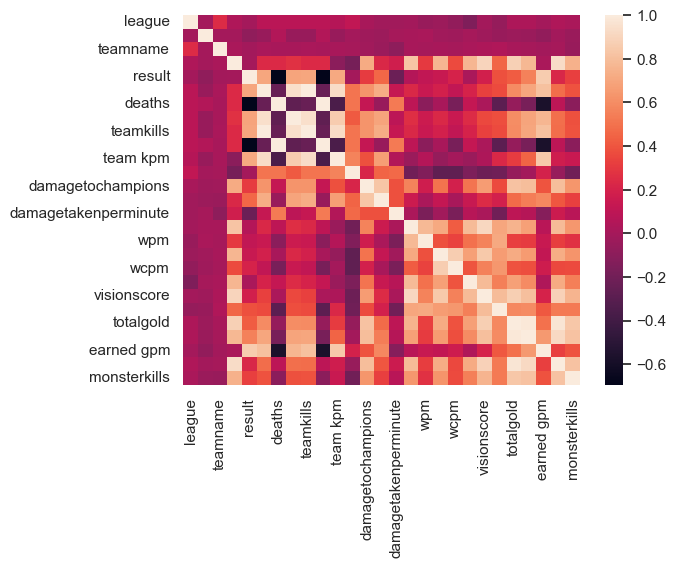

In [366]:
# Displaying heatmap of correlations
sns.heatmap(df_converted.corr())

In [367]:
# Result is all we care about so lets see the correlations for that one
result_corr = df_converted.corr()["result"]
# Let's pretty print these and only to the second decimal place.
pd.options.display.float_format = '{:,.2f}'.format
print(result_corr.sort_values(ascending=0))

result                  1.00
earned gpm              0.86
team kpm                0.71
kills                   0.70
teamkills               0.70
assists                 0.69
earnedgold              0.55
dpm                     0.46
totalgold               0.42
vspm                    0.38
monsterkills            0.32
damagetochampions       0.31
goldspent               0.22
wcpm                    0.20
visionscore             0.18
wardskilled             0.13
wpm                     0.11
wardsplaced             0.06
controlwardsbought      0.01
league                  0.00
gamelength              0.00
ckpm                    0.00
teamname               -0.01
side                   -0.08
damagetakenperminute   -0.23
teamdeaths             -0.69
deaths                 -0.69
Name: result, dtype: float64


### EDA Conclusions
Alright, so the initial assumptions I made about total gold being the most influential factor wasn't right. It's `earned gpm` which is "earned gold per minute". Some other conclusions we can make is that `league`, `gamelength`, `teamname`, `side` don't actually matter too much to winning a match since there values are close to 0. Now we can start modeling and let's start off simple with a multi-linear one.

## Linear and Multi-linear Modeling
For the sake of iterating models, let's see my original assumption of `totalgold` being the the most influential feature.

In [368]:
model = smf.ols(formula="result ~ totalgold", data=df)

regression_results = model.fit()
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 result   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     460.4
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           8.66e-93
Time:                        13:28:14   Log-Likelihood:                -1368.9
No. Observations:                2174   AIC:                             2742.
Df Residuals:                    2172   BIC:                             2753.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5662      0.051    -11.182      0.0

While it is statistically significant, the R^2 is really low at 0.175. Let's now check the top 3 features with the highest correlations.

In [369]:
model = smf.ols(formula="result ~ Q('earned gpm') + Q('team kpm') + teamkills", data=df)

regression_results = model.fit()
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 result   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     2028.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:28:17   Log-Likelihood:                -125.62
No. Observations:                2174   AIC:                             259.2
Df Residuals:                    2170   BIC:                             282.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.3098      0.051    -

### Analysis: Multicollinearity
Great, we can easily see the strong multicollinearity of the features with respect to winning. P is less than 0.05 for all these features which means they're statistically significant. However, R-squared isn't as high as I'd like around 0.95. Maybe we can trim some of the outliers.

### Data Balancing: Identifying and Cleaning Outliers
We can get the leverage vs residual plot and check which are impacting our R^2 of the model. We'll remove those and rerun our model.

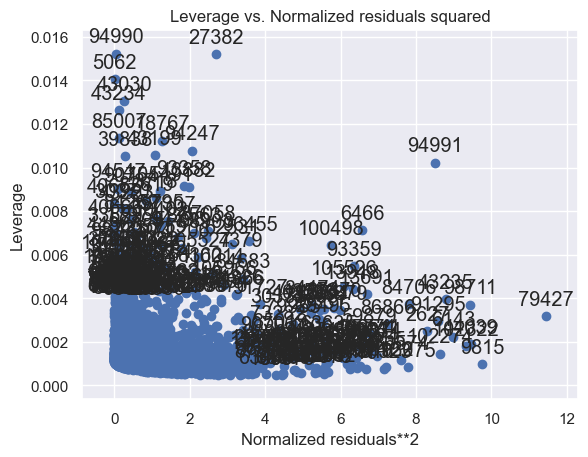

In [370]:
sm.graphics.plot_leverage_resid2(regression_results)
plt.show()

In [ ]:
# The leverage is really, really small, the highest being near 0.016 while some
# of the normalized residuals go past 8. Let's remove the ones farther out on
# the normalized residuals.
outliers = [94991, 79427, 6466, 100498, 9815, 98711, 91295, 43235, 93359, 84706, 2627, 6142, 102274, 94990, 27382]

In [372]:
df_copy = df.copy(deep = True)
df_copy = df_copy.drop(outliers, axis = 0)
model_no_outliers = smf.ols("result ~ Q('earned gpm') + Q('team kpm') + teamkills", data=df_copy).fit()
print(model_no_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:                 result   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     2135.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:28:21   Log-Likelihood:                -77.935
No. Observations:                2159   AIC:                             163.9
Df Residuals:                    2155   BIC:                             186.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.3153      0.050    -

Slightly higher R-squared after removing all those outliers. I could remove more and more outliers here but I don't want to risk removing too many which would result in undersampling the data.

## Decision Tree Classifier Models

In [373]:
x = df_copy.drop(columns="result").copy()
y = df_copy[["result"]].copy()

print(x.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2159 entries, 754 to 114971
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   league                2159 non-null   int64  
 1   side                  2159 non-null   int64  
 2   teamname              2159 non-null   int64  
 3   gamelength            2159 non-null   int64  
 4   kills                 2159 non-null   int64  
 5   deaths                2159 non-null   int64  
 6   assists               2159 non-null   int64  
 7   teamkills             2159 non-null   int64  
 8   teamdeaths            2159 non-null   int64  
 9   team kpm              2159 non-null   float64
 10  ckpm                  2159 non-null   float64
 11  damagetochampions     2159 non-null   int64  
 12  dpm                   2159 non-null   float64
 13  damagetakenperminute  2159 non-null   float64
 14  wardsplaced           2159 non-null   int64  
 15  wpm                   

In [374]:
# Split data into training and testing with 80 for training and 20 for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

In [375]:
print(x_train)

        league  side  teamname  gamelength  kills  deaths  assists  teamkills  \
107195       3     1        29        2049     18      13       48         18   
98675        0     1         1        1939      7      12       20          7   
87995        1     1        16        1457      2      14        6          2   
109990       3     0        36        1591     12       5       35         12   
106894       3     0        12        1661      1       8        2          1   
...        ...   ...       ...         ...    ...     ...      ...        ...   
19666        0     0        15        1499     15       4       41         15   
114970       3     0         2        1933      6      12       17          6   
34306        0     0        13        2187     11       4       28         11   
40355        2     1        20        1686      9      16       23          9   
8374         0     0        29        1745     17       6       41         17   

        teamdeaths  team kp

In [344]:
# Starting off at a small max_depth of 2
dtc_classifier = DecisionTreeClassifier(max_depth=2, random_state=123)
dtc_classifier.fit(x_train, y_train)
prediction = dtc_classifier.predict(x_test)
accuracy = accuracy_score(y_true=y_test, y_pred=prediction)
print(f"Accuracy of DTC: {accuracy}")

Accuracy of DTC: 0.9537037037037037


### Hyperparameter Tuning 
Wow we already have an accuracy of 0.95 with a max_depth of 2. Let's try searching for optimized hyperparameter values by using `GridSearchCV` to get the highest accuracy of the model.

In [ ]:
# NOTE: This takes a while to run so don't run this for the live demo.
parameters = {"max_depth" : np.arange(2,10),
              "criterion": ["gini", "entropy"],
              "max_leaf_nodes" : [2, 5, 10, 25, 50, 100],
              "min_samples_split" : [2, 3, 5, 10, 15, 20]
             }
grid_search_tree = GridSearchCV(DecisionTreeClassifier(), parameters, scoring="accuracy")
grid_search_tree.fit(x_train, y_train)
print(f"Best Estimator: {grid_search_tree.best_estimator_}")

print(f"Best Score: {np.abs(grid_search_tree.best_score_)}")

Best Estimator: DecisionTreeClassifier(max_depth=np.int64(4), max_leaf_nodes=10)
Best Score: 0.9756840077071292


Nice, we can now use the optimized parameters to get a higher accuracy.

In [400]:
dtc_classifier = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10, random_state=123)
dtc_classifier.fit(x_train, y_train)
prediction = dtc_classifier.predict(x_test)
accuracy = accuracy_score(y_true=y_test, y_pred=prediction)
f1_value = f1_score(y_true=y_test, y_pred=prediction)
print(f"Accuracy of DTC with Optimized Parameters: {accuracy}")
print(f"F1 Score Optimized Parameters: {f1_value}")

Accuracy of DTC with Optimized Parameters: 0.9722222222222222
F1 Score Optimized Parameters: 0.9736842105263158


Let's check what the classifier thought the most important features were

In [ ]:
features = x.columns
scores = dtc_classifier.feature_importances_.tolist()
result = pd.DataFrame({"features" : features, "score": scores})
result = result.sort_values(by=["score"], ascending=False)
print(result)

                features  score
23            earned gpm   0.93
5                 deaths   0.06
19           visionscore   0.01
6                assists   0.00
16           wardskilled   0.00
1                   side   0.00
4                  kills   0.00
0                 league   0.00
3             gamelength   0.00
2               teamname   0.00
9               team kpm   0.00
8             teamdeaths   0.00
7              teamkills   0.00
10                  ckpm   0.00
13  damagetakenperminute   0.00
14           wardsplaced   0.00
12                   dpm   0.00
11     damagetochampions   0.00
17                  wcpm   0.00
15                   wpm   0.00
20                  vspm   0.00
18    controlwardsbought   0.00
21             totalgold   0.00
22            earnedgold   0.00
24             goldspent   0.00
25          monsterkills   0.00


So it seems `earned gpm` is at a staggeringly high influencer at 0.93. This makes sense, as the more gold you earn per minute, the faster you can buy more items and become more powerful, leading to a game victory faster. `deaths` plays a bit there too I bet because the less times a player dies, the more they can influence and win the game. `visionscore` is at a low 0.01 but I still want to mention how important and correlated these values are. Maintaining game vision helps give knowledge and when to make the right plays or avoid needless deaths.

Let's see what happens if we select and train based off the top 3 features alone.

In [410]:
def dtc_helper(dtc_classifier, x_train, y_train, x_test, y_test):
    """
    A helper to fit, predict, and get the accuracy.
    """
    dtc_classifier.fit(x_train, y_train)
    prediction = dtc_classifier.predict(x_test)
    accuracy = accuracy_score(y_true=y_test, y_pred=prediction)
    print(f"Accuracy of DTC with Optimized Parameters: {accuracy}\n")

In [411]:
top_feature = df_copy[["earned gpm"]].copy()
top_2_features = df_copy[["earned gpm", "deaths"]].copy()
top_3_features = df_copy[["earned gpm", "deaths", "visionscore"]].copy()

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(top_feature,y, train_size=0.8)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(top_2_features,y, train_size=0.8)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(top_3_features,y, train_size=0.8)

print("earned gpm")
dtc_helper(dtc_classifier=dtc_classifier,
    x_train=x_train_1,
    y_train=y_train_1,
    x_test=x_test_1,
    y_test=y_test_1)

print("earned gpm and deaths")
dtc_helper(dtc_classifier=dtc_classifier,
    x_train=x_train_2,
    y_train=y_train_2,
    x_test=x_test_2,
    y_test=y_test_2)

print("earned gpm, deaths, and vision score")
dtc_helper(dtc_classifier=dtc_classifier,
    x_train=x_train_3,
    y_train=y_train_3,
    x_test=x_test_3,
    y_test=y_test_3)


earned gpm
Accuracy of DTC with Optimized Parameters: 0.9421296296296297

earned gpm and deaths
Accuracy of DTC with Optimized Parameters: 0.9675925925925926

earned gpm, deaths, and vision score
Accuracy of DTC with Optimized Parameters: 0.9652777777777778



This supports how `earned gpm` is so influential to games but `deaths` and `visionscore` still play a vital part. Also shows how accuracy increases as we consider more features.

Retrospective, since we know that `earned gpm`, `deaths`, and `visionscore` are the most influential features now, I went back to update the models to see if we can get a higher R^2.

In [413]:
df_copy = df.copy(deep = True)
df_copy = df_copy.drop(outliers, axis = 0)
model_final = smf.ols("result ~ Q('earned gpm') + deaths + visionscore", data=df_copy).fit()
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                 result   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     2958.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:43:08   Log-Likelihood:                 195.60
No. Observations:                2159   AIC:                            -383.2
Df Residuals:                    2155   BIC:                            -360.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.4449      0.046    -

Yea, we got a higher R^2 at 0.805 versus the trimmed version 0.748, showing how collineated those features are versus my original model.

## Results & Analysis Summary

We discovered that the best features for determining if a team wins the game are the following:
- earned gpm 
- team kpm   
- kills 

My original assumption that total gold was the best is incorrect. The reasoning for this is probably due to game length. The longer the game goes, the more total gold doesn't matter as everyone has a limited amount they can buy. In other words, they can't spend anymore after a certain point. `earned gpm` (earned gol per minute)  the higher this value is, the faster you can buy more items and become more powerful, leading to a game victory faster. `deaths` plays a bit there too I bet because the less times a player dies, the more they can influence and win the game. `visionscore` is at a low 0.01 but I still want to mention how important and correlated these values are. Maintaining game vision helps give knowledge and when to make the right plays or avoid needless deaths.

Because those best three features are so correlated, our accuracy is insanely high for determining winners and losers of matches at 97% for 2024. 

## Conclusion
### Key Insights
- My original assumption of total gold being the best identifier was wrong. This was because gold doesn't matter at some point due to everyone becoming full build so there is a hard limit at some point.
- Winning worlds doesn't mean you win the most matches, I was under the original assumption that people who win the hardest tournament of the year, win the most all year round.

### Lessons Learned
- The more features you have, the better model you have. 
- High correlation doesn't necessarily mean you have the best model. I assumed the highest correlated features were originally `earned gpm`, `team kpm` and `kills`. While `earned gpm` was the highest accurate feature, `team kpm` and `kills` weren't. `deaths` and `visionscore` was. 

### Suggested Improvements for next time
- Use multiple years worth of data to figure out if the features are consistent.
  - I restricted this final project to just one year as usually League of Legends see changes to the rules and the way the game is played year by year to keep the game interesting.
- I'd be interested in trying out if 2024 training accuracy to past years to tell us how drastic these changes are.
- Match prediction is hard, I constrained a lot of things already, but if it was possible to record scrimmages, hours spent on practice, coaching, or anything behind the scenes that wasn't recorded, I feel like the models would be more accurate.